# Mesh

python3 icc_pointcloud.py --mesh=data/R-007_mesh.ply --pointcloud=data/R-007.ply --pointc_noseg=data/R-007_noseg.ply --hight=170.5 --waist=79.5 --hip=98.4;

In [1]:
volunter = "R-007"
h = float(170.5)
real_waist = float(79.5)
real_hip = float(98.4)

In [2]:
from pyntcloud import PyntCloud
import numpy as np

cloud_mesh = PyntCloud.from_file("data/"+ volunter +"_mesh.ply")
mesh = cloud_mesh.points

#### Escalar datos a la altura

In [3]:
# mover eje x, y, z (desde 0)
mesh['x'] = mesh['x'] - min(mesh['x'])
mesh['y'] = mesh['y'] - min(mesh['y'])
mesh['z'] = mesh['z'] - min(mesh['z'])

# calculo factor de escala
scale = h / max(mesh['y'])

# escalar x, y, z
mesh['y'] = mesh['y']*scale
mesh['x'] = mesh['x']*scale
mesh['z'] = mesh['z']*scale

scale_mesh = PyntCloud(mesh)

#### Ubicación punto Y

In [4]:
epsilon = h * 1 / 100

centroid_y = scale_mesh.centroid[1]

list_y = []
yi = centroid_y
yj = centroid_y

for i in range(25):
    yi = yi - 0.7     # R033(+0.7)
    yj = yj + 0.3   # R002,R051(+0.3)
    list_y.append(yi)
    list_y.append(yj)
    
list_y.append(centroid_y)
list_y.sort()

data_filter = {}

for y in list_y:
    yselect = mesh[(mesh['y'] <= (y + epsilon)) & (mesh['y'] >= (y - epsilon))]
    yselect.sort_values('y')    
    data_filter[y] = yselect

#### Construir elipse

In [5]:
# Ellipse fitting

import numpy as np
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

ellipses = {}

for y in data_filter.keys():
    x = data_filter[y]['x']
    z = data_filter[y]['z']
    
    data_points = np.column_stack([x, z])
    
    ell = EllipseModel()
    ell.estimate(data_points)
    
    xc, zc, a, b, theta = ell.params
    
    ellipses[y] = [a, b]

#### Perimetro de la elipse (Ramanujan's approximation)

In [6]:
import math

def calculate_perimeter(a,b):
    perimeter = math.pi*(3*(a+b) - math.sqrt((3*a + b)*(a + 3*b)))
    return perimeter

In [7]:
results = {}

errormin = 100
yi_waist = 0
waistmin = 0
yi_hip = 0
hipmax = 0

for y in ellipses.keys():   
    
    ya, yb = ellipses[y]    
    calculate_waist = calculate_perimeter(ya, yb)  
    calculate_hip = calculate_perimeter(ya, yb) 
    
    # Error medido vs calculado
    error_waist = abs(real_waist - calculate_waist)        
    error_hip = abs(real_hip - calculate_hip)    
    results[y] = [calculate_waist, error_waist, calculate_hip, error_hip]
     
    # Cadera perimetro mayor
    if calculate_hip > (hipmax + 3) and y < centroid_y: # R039(hmax + 3) 
        errormaxhip, yi_hip, hipmax = error_hip, y, calculate_hip
        
    # Cintura minimo error
    if error_waist < errormin:
        errormin, yi_waist, waistmin = error_waist, y, calculate_waist   
    
#print("errormin, yideal, waistmin = ", [errormin, yi_waist, waistmin])
#print("errormaxhip, yideal, hipmax = ", [errormaxhip, yi_hip, hipmax])

#### Graficar el resultado

In [8]:
from matplotlib.ticker import MaxNLocator

 
ID =  R-007
Mesh Waist = 79.191 (Error = 0.309)
Mesh Hip = 98.841 (Error = 0.441)


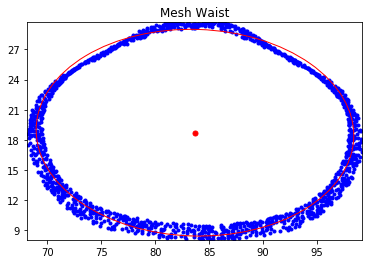

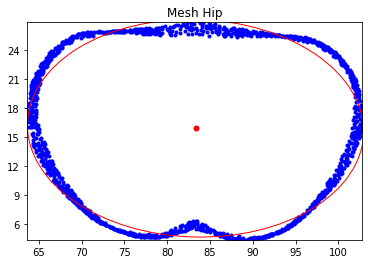

In [21]:
for y in [yi_waist, yi_hip]:
    x = data_filter[y]['x']
    z = data_filter[y]['z']
    
    data_points = np.column_stack([x, z])
    
    ell = EllipseModel()
    ell.estimate(data_points)
    
    xc, zc, a, b, theta = ell.params
    
    ellipses[y] = [a, b]
    
    fig, axs = plt.subplots(1, sharex=True, sharey=True)
    if y == yi_waist:
        title = "Mesh Waist" 
    else:
        title = "Mesh Hip"
    axs.set_title(title) #+ str(round(y, 3))
    axs.scatter(x, z, color='blue', marker='.')
    axs.scatter(xc, zc, color='red', s=100, marker='.')
    axs.set_xlim(x.min(), x.max())
    axs.set_ylim(z.min(), z.max())
    axs.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ell_patch = Ellipse((xc, zc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')
    axs.add_patch(ell_patch)  
    
    if y == yi_waist:
        calculate_waist = round(calculate_perimeter(a, b),3)
        error_waist = round(abs(real_waist - calculate_waist),3)
        print(" ")
        print("ID = ", volunter)
        print("Mesh Waist = "+str(calculate_waist)+" (Error = "+ str(error_waist) +")") 
        plt.savefig("mesh_waist_ellipses.png", dpi=300)
    else:
        calculate_hip = round(calculate_perimeter(a, b),3)
        error_hip = round(abs(real_hip - calculate_hip),3)
        print("Mesh Hip = "+str(calculate_hip)+" (Error = "+ str(error_hip) +")")
        plt.savefig("mesh_hip_ellipses.png", dpi=300)
    
plt.show()

In [10]:
import pandas as pd

# copy mesh color
copy_mesh = mesh.copy()
copy_mesh['red'] = 0
copy_mesh['green'] = 255
copy_mesh['blue'] = 0

# waist data
waist_data = data_filter[yi_waist]
waist_data['red'] = 255
waist_data['green'] = 0
waist_data['blue'] = 0

hip_data = data_filter[yi_hip]
hip_data['red'] = 0
hip_data['green'] = 0
hip_data['blue'] = 255

icc_data = PyntCloud(pd.concat([waist_data, hip_data]))

/home/alexa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/alexa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/alexa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [11]:
# OJO: marge solo para visualizar 
new_dataset = copy_mesh.merge(icc_data.points, how='outer', indicator='union')
#new_dataset.describe()

new_mesh = PyntCloud(new_dataset)
new_mesh.plot(backend="threejs")

In [12]:
print("yi_hip", yi_hip)
print("yi_waist", yi_waist)

yi_hip 88.16014099121087
yi_waist 102.16014099121092


# Point Cloud

In [13]:
pointcloud = PyntCloud.from_file("data/"+ volunter +".ply").points
q_pointcloud = pointcloud.copy()

In [14]:
# Escalar datos a la altura

# mover eje x, y, z (desde 0)
q_pointcloud['x'] = q_pointcloud['x'] - min(q_pointcloud['x'])
q_pointcloud['y'] = q_pointcloud['y'] - min(q_pointcloud['y'])
q_pointcloud['z'] = q_pointcloud['z'] - min(q_pointcloud['z'])

# calculo factor de escala
scale_pc = h / max(q_pointcloud['y'])

# escalar x, y, z
q_pointcloud['x'] = q_pointcloud['x']*scale_pc
q_pointcloud['y'] = q_pointcloud['y']*scale_pc
q_pointcloud['z'] = q_pointcloud['z']*scale_pc

In [18]:
#yi_waist_pc = h - yi_waist
#yi_hip_pc = h - yi_hip
yi_waist_pc = yi_waist # R-002,4,5,6,7,11,13,33,39,51
yi_hip_pc = yi_hip

epsilon_pc = h * 1 / 100

waist_pointcloud = q_pointcloud[(q_pointcloud['y'] <= (yi_waist_pc + epsilon_pc)) & 
                                (q_pointcloud['y'] >= (yi_waist_pc - epsilon_pc))]
hip_pointcloud = q_pointcloud[(q_pointcloud['y'] <= (yi_hip_pc + epsilon_pc)) & 
                                (q_pointcloud['y'] >= (yi_hip_pc - epsilon_pc))]

 
PointCloud Waist = 86.229 (Error = 6.729)
PointCloud Hip = 100.116 (Error = 1.716)


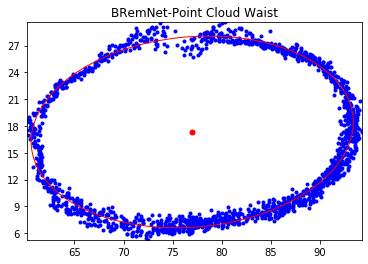

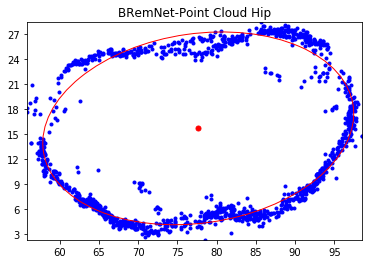

In [22]:
indices = ["PointCloud Waist", "PointCloud Hip"]

for ind in indices:
    if ind == "PointCloud Waist":
        x = waist_pointcloud['x']
        z = waist_pointcloud['z']
        y = yi_waist
    else:
        x = hip_pointcloud['x']
        z = hip_pointcloud['z']
        y = yi_hip
    
    data_points = np.column_stack([z, x]) #x, z
    
    ell = EllipseModel()
    ell.estimate(data_points)   
    #xc, zc, a, b, theta = ell.params
    zc, xc, a, b, theta = ell.params
    
    ellipses[y] = [a, b]
    
    fig, axs = plt.subplots(1, sharex=True, sharey=True)        
    #axs.set_title(ind) # + " y = " + str(round(y, 3))
    axs.scatter(z, x, color='blue', marker='.')
    axs.scatter(zc, xc, color='red', s=100, marker='.')
    axs.set_xlim(z.min(), z.max()) 
    axs.set_ylim(x.min(), x.max())
    axs.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ell_patch = Ellipse((zc, xc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')
    axs.add_patch(ell_patch)
    
    if ind == "PointCloud Waist":
        axs.set_title("BRemNet-Point Cloud Waist")
        calculate_waist = round(calculate_perimeter(a, b),3)
        error_waist = round(abs(real_waist - calculate_waist),3)
        print(" ")
        print("PointCloud Waist = "+str(calculate_waist)+" (Error = "+ str(error_waist) +")")
        plt.savefig("pointcloud_waist_ellipses.png", dpi=300)
    else:
        axs.set_title("BRemNet-Point Cloud Hip")
        calculate_hip = round(calculate_perimeter(a, b),3)
        error_hip = round(abs(real_hip - calculate_hip),3)
        print("PointCloud Hip = "+str(calculate_hip)+" (Error = "+ str(error_hip) +")")
        plt.savefig("pointcloud_hip_ellipses.png", dpi=300)

plt.show()

In [20]:
# colorear waist_data
waist_data = waist_pointcloud.copy()
waist_data['red'] = 255
waist_data['green'] = 0
waist_data['blue'] = 0

hip_data = hip_pointcloud.copy()
hip_data['red'] = 0
hip_data['green'] = 0
hip_data['blue'] = 255

icc_data = PyntCloud(pd.concat([waist_data, hip_data]))

new_dataset = q_pointcloud.merge(icc_data.points, how='outer', indicator='union')
new_cloud = PyntCloud(new_dataset)
new_cloud.plot(backend="threejs")

# Point Cloud no segmentado

In [26]:
pointcloud_noseg = PyntCloud.from_file("data/"+ volunter +"_noseg.ply").points
q_pointcloud_noseg = pointcloud_noseg.copy()

# Escalar datos a la altura
q_pointcloud_noseg['x'] = q_pointcloud_noseg['x'] - min(q_pointcloud_noseg['x'])
q_pointcloud_noseg['y'] = q_pointcloud_noseg['y'] - min(q_pointcloud_noseg['y'])
q_pointcloud_noseg['z'] = q_pointcloud_noseg['z'] - min(q_pointcloud_noseg['z'])
# calculo factor de escala
scale_noseg = h / max(q_pointcloud_noseg['y'])
# escalar x, y, z
q_pointcloud_noseg['x'] = q_pointcloud_noseg['x']*scale_noseg
q_pointcloud_noseg['y'] = q_pointcloud_noseg['y']*scale_noseg
q_pointcloud_noseg['z'] = q_pointcloud_noseg['z']*scale_noseg

#R054(yi_waist_pc) 
waist_pointcloud_noseg = q_pointcloud_noseg[(q_pointcloud_noseg['y'] <= (yi_waist + epsilon_pc)) & 
                                            (q_pointcloud_noseg['y'] >= (yi_waist - epsilon_pc))] 
hip_pointcloud_noseg = q_pointcloud_noseg[(q_pointcloud_noseg['y'] <= (yi_hip + epsilon_pc)) & 
                                          (q_pointcloud_noseg['y'] >= (yi_hip - epsilon_pc))]

 
PointCloud-NoSeg Waist = 390.329 (Error = 310.829)
PointCloud-NoSeg Hip = 470.906 (Error = 372.506)


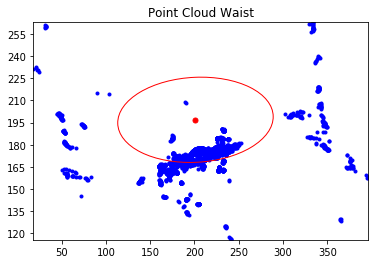

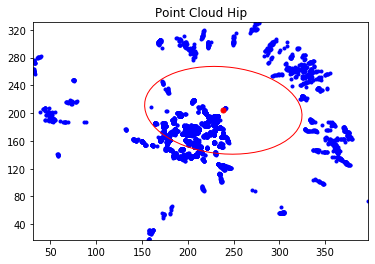

In [27]:
indices_noseg = ["PointCloud-Noseg Waist", "PointCloud-Noseg Hip"]

for ind in indices_noseg:
    if ind == "PointCloud-Noseg Waist":
        x = waist_pointcloud_noseg['x']
        z = waist_pointcloud_noseg['z']
        y = yi_waist
    else:
        x = hip_pointcloud_noseg['x']
        z = hip_pointcloud_noseg['z']
        y = yi_hip
    
    data_points = np.column_stack([z, x]) #x, z
    
    ell = EllipseModel()
    ell.estimate(data_points)   
    #xc, zc, a, b, theta = ell.params
    zc, xc, a, b, theta = ell.params
    
    ellipses[y] = [a, b]
    
    fig, axs = plt.subplots(1, sharex=True, sharey=True)        
    #axs.set_title(ind) #+ " y = " + str(round(y, 3))
    axs.scatter(z, x, color='blue', marker='.')
    axs.scatter(zc, xc, color='red', s=100, marker='.')
    axs.set_xlim(z.min(), z.max())
    axs.set_ylim(x.min(), x.max())
    axs.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ell_patch = Ellipse((zc, xc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')
    axs.add_patch(ell_patch)
    
    if ind == "PointCloud-Noseg Waist":
        axs.set_title("Point Cloud Waist")
        calculate_waist = round(calculate_perimeter(a, b),3)
        error_waist = round(abs(real_waist - calculate_waist),3)
        print(" ")
        print("PointCloud-NoSeg Waist = "+str(calculate_waist)+" (Error = "+ str(error_waist) +")")
        plt.savefig("pointcloudnoseg_waist_ellipses.png", dpi=300)
    else:
        axs.set_title("Point Cloud Hip")
        calculate_hip = round(calculate_perimeter(a, b),3)
        error_hip = round(abs(real_hip - calculate_hip),3)
        print("PointCloud-NoSeg Hip = "+str(calculate_hip)+" (Error = "+ str(error_hip) +")")
        plt.savefig("pointcloudnoseg_hip_ellipses.png", dpi=300)
    
plt.show()

In [28]:
sample = q_pointcloud_noseg.sample(n=10000)
#sample['red'] = 0
#sample['green'] = 255
#sample['blue'] = 0

# colorear waist_data
waist_data_noseg = waist_pointcloud_noseg.copy()
waist_data_noseg['red'] = 255
waist_data_noseg['green'] = 0
waist_data_noseg['blue'] = 0

hip_data_noseg = hip_pointcloud_noseg.copy()
hip_data_noseg['red'] = 0
hip_data_noseg['green'] = 0
hip_data_noseg['blue'] = 255

icc_data_noseg = PyntCloud(pd.concat([waist_data_noseg, hip_data_noseg]))

new_dataset_noseg = sample.merge(icc_data_noseg.points, how='outer', indicator='union')
new_cloud_noseg = PyntCloud(new_dataset_noseg)
new_cloud_noseg.plot(backend="threejs")